In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, norm
import yfinance as yf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook"])

# Download S&P 500 from 2024-04-25 to 2025-04-25
df = yf.download('^GSPC',
                 start='2024-04-25',
                 end  ='2025-04-25',
                 progress=False)
display(df.head())

# daily log-returns
rets = np.log(df['Close'] / df['Close'].shift(1)).dropna()
N    = len(rets)

YF.download() has changed argument auto_adjust default to True



1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,


In [ ]:
# Estimate parameters from observed returns
mu_hat, sigma_hat = rets.mean(), rets.std(ddof=1)

# Observed KS test
ks_obs = kstest(
    rets, lambda x: norm.cdf(x, loc=mu_hat, scale=sigma_hat)
)
D_obs, p_obs = ks_obs.statistic, ks_obs.pvalue

# Parametric bootstrap
M = 5000
D_sim = np.empty(M)

for i in tqdm(range(M)):
    # Generate sample and compute KS statistic
    sample = np.random.normal(mu_hat, sigma_hat, size=N)
    mu_i, sigma_i = sample.mean(), sample.std(ddof=1)
    D_sim[i] = kstest(
        sample, lambda x: norm.cdf(x, loc=mu_i, scale=sigma_i)
    ).statistic

print(f"   Observed p-value = {p_obs[0]:.4f} \
    (not valid, print just for fun)")
# Calculate Monte Carlo p-value
p_MC = (1 + np.sum(D_sim >= D_obs)) / (M + 1)
print(f"Monte Carlo p-value = {p_MC:.4f}")

# Visualization
plt.figure()
plt.hist(D_sim, bins=30, alpha=0.7, density=True, 
         label='Simulated KS Statistics')
plt.axvline(D_obs, color='red', linestyle='--', linewidth=2, 
            label=f'Observed KS D = {D_obs[0]:.4f}')
plt.xlabel('KS D Statistic')
plt.ylabel('Density')
plt.title('Distribution of KS Statistics under Fitted Normal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
from scipy.optimize import brentq

df = pd.read_csv('data/data.csv',
                 names=['K','S','T','r','MarketPrice'],
                 skiprows=1)

In [4]:
def bsm_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

sigma_fixed = 0.17
df['ModelPrice'] = df.apply(
    lambda row: bsm_call_price(row['S'],
                               row['K'],
                               row['T'],
                               row['r'],
                               sigma_fixed),
    axis=1
)
mse_all = np.mean((df['ModelPrice'] - df['MarketPrice'])**2)
print(f"MSE over all expirations (σ={sigma_fixed}): {mse_all:.4f}")

for T, group in df.groupby('T'):
    mse_T = np.mean((group['ModelPrice'] - group['MarketPrice'])**2)
    print(f"T={T:.4f}  MSE={mse_T:.3f}  (RMSE≈{np.sqrt(mse_T):.2f})")

MSE over all expirations (σ=0.17): 25.5198
T=0.0466  MSE=20.887  (RMSE≈4.57)
T=0.1233  MSE=29.995  (RMSE≈5.48)
T=0.2000  MSE=35.895  (RMSE≈5.99)
T=0.2767  MSE=29.586  (RMSE≈5.44)
T=0.4493  MSE=11.494  (RMSE≈3.39)
T=0.6986  MSE=7.462  (RMSE≈2.73)
T=0.9479  MSE=4.649  (RMSE≈2.16)


In [5]:
def implied_vol(MktP, S, K, T, r):
    # intrinsic‐floor to avoid root failure
    if MktP <= max(S - K*np.exp(-r*T), 0.0):
        return 0.0
    f = lambda vol: bsm_call_price(S, K, T, r, vol) - MktP
    return brentq(f, 1e-6, 5.0)


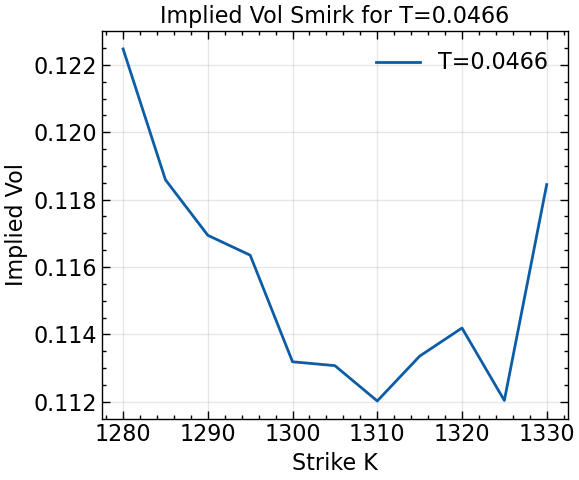

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))  

T0 = 0.046575
smirk = df[df['T'] == T0].copy()
smirk['ImpVol'] = smirk.apply(
    lambda r: implied_vol(r['MarketPrice'], r['S'], r['K'], r['T'], r['r']),
    axis=1
)

ax.plot(smirk['K'], smirk['ImpVol'], label=f'T={T0:.4f}')
ax.set_title(f'Implied Vol Smirk for T={T0:.4f}')
ax.set_xlabel('Strike K')
ax.set_ylabel('Implied Vol')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()